In [1]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    Define the Integrate-and-Fire class
"""

class integrate_and_fire:
    """
        A class representing the integrate and fire neuron model
    """
    def __init__(self, R=10, C=1, Vthr=5, Vspk=70, I=0.001, It=50, It_start=10):
        """
            Defined Constants/Initial values:
            R = 10 MOhm
            C = 1 nF
            Vthr = 5 mV
            Vspk = 70 mV
            I = 1 nA
            It = 50 ms
            It_start = 10 ms
        """
        
        # Assign values to object parameters
        self.R = R
        self.C = C
        self.Vthr = Vthr
        self.Vspk = Vspk
        self.I = I
        self.It = It
        self.It_start = It_start
        self.V = 0 # set initial voltage
        
        # Create list to store V values
        self.V_vals = []
        
        # create counter to determine current step
        self.counter = 0
        
        # set reset flag so we can reset voltage
        self.reset = False
        
    def new_voltage(self, V, I, time_step=1):
        """
            Calculates new voltage using Euler's method
        """
        return self.V + time_step*(I - (V/self.R))/self.C
    
    def set_voltage(self,V):
        """
            Sets appropriate voltage compared to threshold
        """
        # check if voltage less than threshold
        if V < self.Vthr:
            return V
        else: # if over threshold, set voltage to Vspk, next V will be 0
            self.reset = True
            return self.Vspk    
    
    def step(self, time_step=1):
        """
            Runs one step of the model
        """
        # set current injection start/duration
        if self.counter > self.It_start and self.counter <= self.It_start+self.It:
            I = self.I
        else:
            I = 0
        self.counter += 1 # increment counter
        
        # reset voltage if flag set
        if self.reset:
            self.V = 0
            
            # "reset" reset flag
            self.reset = False
        else:
            # calculate new voltage
            V = self.new_voltage(self.V, I)
        
            # set new voltage
            self.V = self.set_voltage(V)
            
        # append voltage to list
        self.V_vals.append(self.V)
        

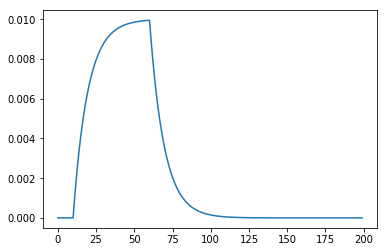

In [3]:
"""
    Run model
"""
def run_model(model, iterations=200):
    # run model for iterations
    for _ in range(iterations):
        iafmodel.step()
    
    # set time
    time = [i for i in range(iterations)]
    
    # plot voltage
    plt.figure()
    plt.plot(time, model.V_vals)
    plt.show()
    
# create integrate and fire model with defaults
iafmodel = integrate_and_fire()

# run model
run_model(iafmodel)